In [ ]:
!nvidia-smi

Mon Nov  2 07:10:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* @file 深度學習基礎 / overfitting.ipynb
  * @brief overfitting 模型實作 

  * 此份程式碼是以教學為目的，附有完整的架構解說。

  * @author 人工智慧科技基金會 AI 工程師 - 康文瑋
  * Email: run963741@aif.tw
  * Resume: https://www.cakeresume.com/run963741

  * 最後更新日期: 2020/11/26

# Overfitting

`Overfitting` 說明模型在訓練集上表現的很好，但是在測試集 (Testing) 上的表現不佳，通常會發現訓練集的 `Loss` 不斷的下降，但是測試集的 `Loss` 反覆震盪，在預測邊界上會呈現類似下圖的樣子：

* `under-fitting`: 模型在訓練集以及測試集上表現都很差，這表示模型完全沒有學習能力。
* `normal`: 模型在訓練資料集上表現很好，而且在測試集上表現也不錯，這表示模型的泛化性佳 (Regularization)。
* `Over-fitting`: 模型在訓練資料集上表現很好，但是在測試集上表現不佳，這表示模型的泛化性差 (Regularization)。

普遍來說，測試集的表現會比訓練集還要差一點點，這是很正常的事情，但是我們不希望這個差距過於巨大，而是希望訓練集與測試集的表現越相近越好。



<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1gZjDc-u9wt9If2yHv3ApewQhWIBtUhGl' width="700"/>
<figcaption></figcaption></center>
</figure>

Resource: http://mlwiki.org/index.php/Overfitting

通常會有幾種原因導致 `overfitting` 發生：

* 模型過於複雜 (簡單的任務用複雜的模型)
* 資料量太少無法涵蓋所有情況
* 資料中含有雜訊 (可能存在某幾筆資料錯誤資料)
* 訓練前忘記打亂資料集再切訓練集和測試集 (這是大家常常忘記做的事情，請一定要做 shuffle，確保訓練集和測試集的分佈一致)

在實務上常常從資料下手，盡可能的搜集資料集，並確保資料與標籤是否正確。

# 載入函數

In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib

os.chdir('/content/drive/Shared drives/類技術班教材/標準版/ 深度學習基礎/DL_part2')

# 模擬資料集

In [ ]:
def linear_model(rseed=222, n_samples=30):
    " Generate data according to a linear model"
    np.random.seed(rseed)

    data = np.random.normal(-1, 1, (n_samples, 2))
    data[:n_samples // 2] -= 1.5
    data[n_samples // 2:] += 1.5

    labels = np.ones(n_samples)
    labels[:n_samples // 2] = 0

    return data, labels

## 產生資料集

In [ ]:
n_samples = 2000
X, y = linear_model(n_samples = n_samples)

# 將標籤 y 做 One-hot encoding
y = tf.keras.utils.to_categorical(y)

In [ ]:
print('X: ', X[:5])
print('y: ', y[:5])

X:  [[-0.53657498 -2.22423031]
 [-2.0413418  -1.49873534]
 [-3.26383531 -1.77807234]
 [-3.40546956 -1.49812661]
 [-3.02074247 -2.19104713]]
y:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### 資料視覺化

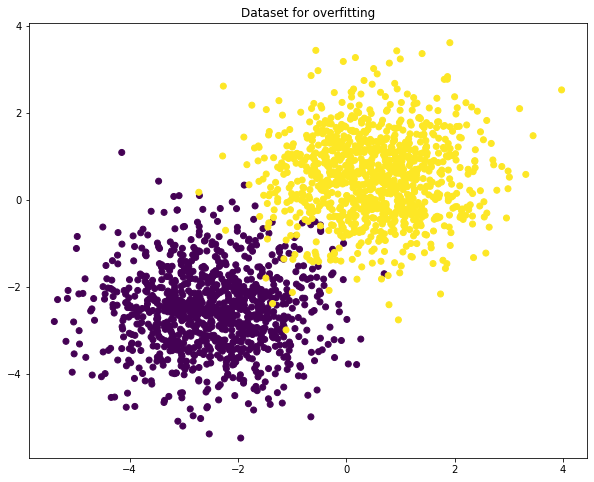

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = y[:,1])
plt.title('Dataset for overfitting')
plt.show()

## 切割訓練集 (Training set) 以及測試集 (testing set)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

print('Training data size: ', X_train.shape)
print('Testing data size: ', X_test.shape)

Training data size:  (1200, 2)
Testing data size:  (800, 2)


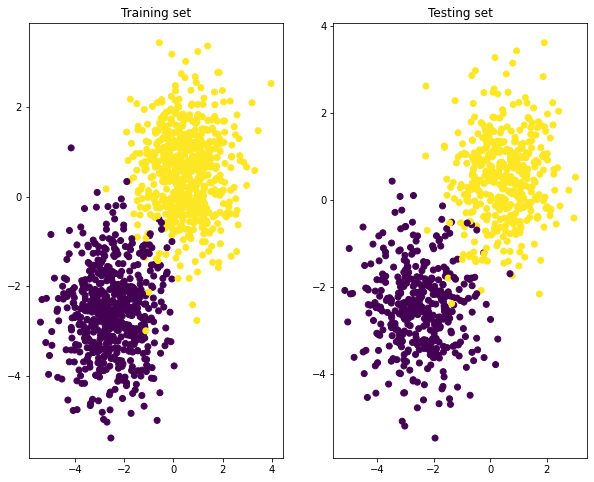

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c = y_train[:,1])
plt.title('Training set')

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c = y_test[:,1])
plt.title('Testing set')
plt.show()

## 建立模型

In [ ]:
input = tf.keras.layers.Input(shape=(2,), name='Input_layer')
dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')(input)
dense2 = tf.keras.layers.Dense(64, activation='relu', name='dense2')(dense1)
dense3 = tf.keras.layers.Dense(128, activation='relu', name='dense3')(dense2)
dense4 = tf.keras.layers.Dense(64, activation='relu', name='dense4')(dense3)
output = tf.keras.layers.Dense(2, activation='softmax', name='Output_layer')(dense4)

model = tf.keras.Model(input, output)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 32)                96        
_________________________________________________________________
dense2 (Dense)               (None, 64)                2112      
_________________________________________________________________
dense3 (Dense)               (None, 128)               8320      
_________________________________________________________________
dense4 (Dense)               (None, 64)                8256      
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 130       
Total params: 18,914
Trainable params: 18,914
Non-trainable params: 0
__________________________________________________

## 訓練模型

Tensorflow 最常使用來編譯模型的方式是透過 `.compile` 來指定損失函數 (loss function) 、優化器 (optimizer)、評估指標 (metrics) 以及 callbacks。

分類任務參數：
* `loss`: 分類任務最常使用的損失函數為 `cross_entropy`，若是二元分類，則使用 `binary_cross_entropy`；若是多元分類，則使用 `categorical_crossentropy` 或是 `sparse_categorical_crossentropy` (這兩種差別在於標籤是否有做 `One-hot encoding`，有做的話就使用 `categorical_crossentropy`，反之就使用 `sparse_categorical_crossentropy`)。

* `optimizer`: 優化器決定參數更新的方式，目前最常使用的優化器為 `SGD, RMSprop, Adam`，近期研究也有新的優化器，例如 `RangerLars`。

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# 訓練模型
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32)

Epoch 1/500
38/38 [==============================] - 0s 8ms/step - loss: 0.3287 - accuracy: 0.8892 - val_loss: 0.1156 - val_accuracy: 0.9775
Epoch 2/500
38/38 [==============================] - 0s 4ms/step - loss: 0.0677 - accuracy: 0.9825 - val_loss: 0.0693 - val_accuracy: 0.9737
Epoch 3/500
38/38 [==============================] - 0s 4ms/step - loss: 0.0511 - accuracy: 0.9817 - val_loss: 0.0650 - val_accuracy: 0.9737
Epoch 4/500
38/38 [==============================] - 0s 4ms/step - loss: 0.0508 - accuracy: 0.9842 - val_loss: 0.0591 - val_accuracy: 0.9762
Epoch 5/500
38/38 [==============================] - 0s 4ms/step - loss: 0.0457 - accuracy: 0.9833 - val_loss: 0.0648 - val_accuracy: 0.9750
Epoch 6/500
38/38 [==============================] - 0s 4ms/step - loss: 0.0474 - accuracy: 0.9817 - val_loss: 0.0578 - val_accuracy: 0.9775
Epoch 7/500
38/38 [==============================] - 0s 4ms/step - loss: 0.0442 - accuracy: 0.9833 - val_loss: 0.0598 - val_accuracy: 0.9762
Epoch 8/500
3

# 訓練結果評估

## Loss and accuracy

下圖顯示訓練集與測試集的 `loss` 以及 `accuracy`，隨著 `Epochs` 增加，訓練集與測試集的差距也越來越大，這就是 `overfitting` 的現象。

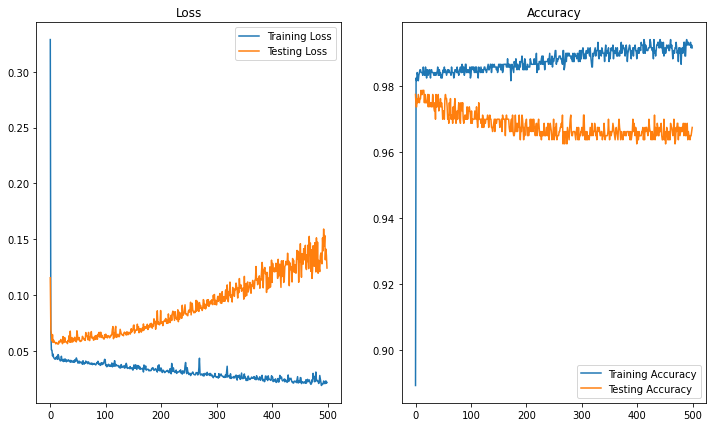

In [ ]:
# 視覺化訓練過程
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 7))

# 繪製 Training loss 和 Validation loss
plt.subplot(121)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Testing Loss')
plt.legend(loc='best')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(122)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Testing Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')

plt.show()

## Prediction boundary

接下來，我們將模型的預測邊界畫出來，觀察 `overfitting` 會有什麼現象。

In [ ]:
# 產生網格資料
x1=np.linspace(-6,4.5,200)
x2=np.linspace(-6,4.5,200)

x1, x2 = np.meshgrid(x1, x2)
plot_data = np.array(list(zip(x1.flatten(), x2.flatten())))

print('Plot data shape: ', plot_data.shape)

Plot data shape:  (40000, 2)


In [ ]:
# 將網格上每個點都進行預測

plot_y = model.predict(plot_data)
plot_y_class = np.argmax(plot_y, axis=-1)

print(plot_y_class)

[0 0 0 ... 1 1 1]


下圖中的紅藍區域表示模型在訓練時所決定出來的預測邊界，當我們把模型的複雜度提高之後，模型對於訓練集的分類表現就會提高，在下左圖中，模型有嘗試著將兩類之間的點分的越來越細，預測邊界也是越來越刁鑽，但是若將此預測邊界應用在測試集上，就會發現一些模型無法在測試集上有好的表現，這是因為模型過度依賴訓練集，嘗試將訓練集的所有情況都背下來。

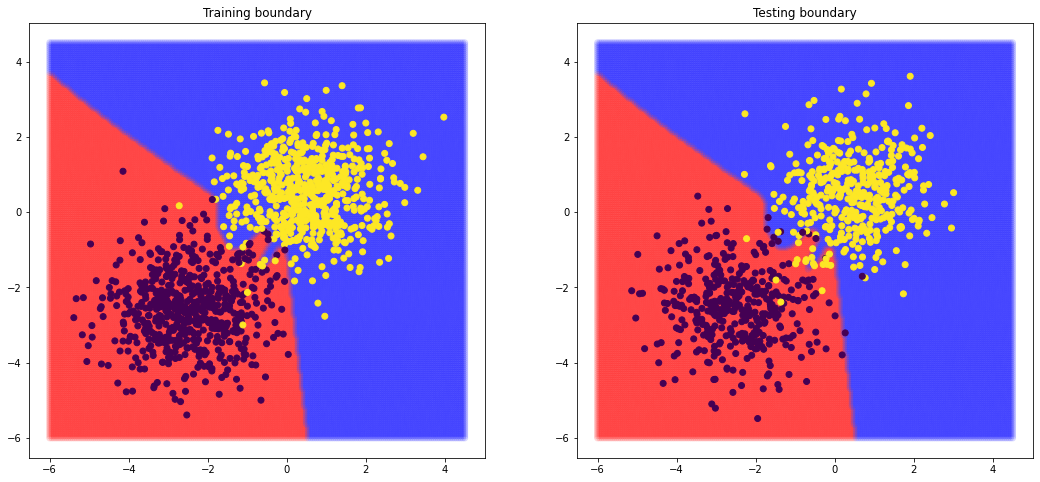

In [ ]:
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
colors = ['red', 'blue']
plt.scatter(x1, x2, c = plot_y_class, alpha=0.1, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(X_train[:,0], X_train[:,1], c = y_train[:,1])
plt.title('Training boundary')

plt.subplot(1,2,2)
colors = ['red', 'blue']
plt.scatter(x1, x2, c = plot_y_class, alpha=0.1, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(X_test[:,0], X_test[:,1], c = y_test[:,1])
plt.title('Testing boundary')

plt.show()

# 減緩 `overfitting` 的方法

要減緩 `overfitting` 的方法除了在資料上動手腳之外 (例如重新標籤、刪除離群值)，在模型方面有四種方式來減緩 `overfitting`。

* 正則化 (Regularization): 懲罰表現過度突出的權重，其實就是梯度更新時，針對權重進行縮小，讓權重不會隨著資料改變而發生太大的變化。
* Early stopping: 在 `overfitting` 發生之前，提前停止訓練。
* Dropout: 在訓練過程中，隨機將固定比例的神經元權重設為 `0`，避免所有神經元都朝著同一個方向更新，這個方法簡單又粗暴。
* 降低模型複雜度: 層數少一點、神經元數量少一點。


## 正則化 (Regularization)



這個方法是透過在損失函數後面加上 `L1` 或是 `L2`，懲罰表現過頭的權重。

$$
\begin{aligned}
& L1\;regularization: L = L_0(\theta) + \frac{\lambda}{n}\sum|\theta| \\
& L2\;regularization: L = L_0(\theta) + \frac{\lambda}{2n}\sum\theta^2 \\
& L1\;L2\;regularization: L = L_0(\theta) + \frac{\lambda}{n}\sum|\theta| + \frac{\lambda}{2n}\sum\theta^2
\end{aligned}
$$

當加上 `L2` 或 `L2` 之後，在進行梯度下降時，權重會進行一次縮小，假設進行 `L2` 如下式：

1. 首先計算 $\theta$ 的梯度：
$$
\frac{\partial L}{\partial \theta}=\frac{\partial L_0}{\partial \theta} + \frac{\lambda}{n}\theta
$$

2. 使用該梯度進行梯度更新：
$$
\hat{\theta}:=\theta - \eta(\frac{\partial L_0}{\partial \theta} + \frac{\lambda}{n}\theta)
$$

3. 化簡上式: 
$$
\hat{\theta}:=(1-\eta\frac{\lambda}{n})\theta-\eta\frac{\partial L_0}{\partial \theta}
$$

觀察上式，我們發現除了保有原始梯度下降的項 $\eta\frac{\partial L_0}{\partial \theta}$ 之外，權重 $\theta$ 還多乘上一個衰減係數 $(1-\eta\frac{\lambda}{n})$，`Regularization` 就是透過此方式來限制模型權重的表現。

In [ ]:
from tensorflow.keras.regularizers import l1_l2

### 建立模型

In [ ]:
def build_model_regular(l1, l2):

  input = tf.keras.layers.Input(shape=(2,), name='Input_layer')
  # 正則項在每一層都可以使用, l1 和 l2 表示上面公式中的 lambda 項
  dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=l1_l2(l1=l2, l2=l2))(input)
  dense2 = tf.keras.layers.Dense(64, activation='relu', name='dense2', kernel_regularizer=l1_l2(l1=l2, l2=l2))(dense1)
  dense3 = tf.keras.layers.Dense(128, activation='relu', name='dense3', kernel_regularizer=l1_l2(l1=l2, l2=l2))(dense2)
  dense4 = tf.keras.layers.Dense(64, activation='relu', name='dense4', kernel_regularizer=l1_l2(l1=l2, l2=l2))(dense3)
  output = tf.keras.layers.Dense(2, activation='softmax', name='Output_layer')(dense4)

  model = tf.keras.Model(input, output)

  return model

### 訓練模型

這邊測試不同的 `L1` 和 `L2` 對於模型的訓練效果。

In [ ]:
# l1 和 l2 的係數通常介於 0 ~ 1 之間，級距通常是 0.1, 0.01, 0.001,... 來做調整
l1_l2_list = [(0, 0), (0, 1e-2), (1e-2, 0), (1e-3, 1e-3)]

# hyperparameter
batch_size = 32
epochs = 100

# 儲存模型
model_list = []

# 建立兩個 list 記錄選用不同 regularizer 數值的訓練結果
train_loss_list = []
train_acc_list = []

# 建立兩個 list 記錄選用不同 regularizer 數值的驗證結果
valid_loss_list = []
valid_acc_list = []

# 迭代不同的 regularizer 數值去訓練模型
for l1, l2 in l1_l2_list:
    print('Building a model with regularizer L1: {}, L2: {}'.format(l1, l2))

    # 確保每次都是訓練新的模型，而不是接續上一輪的模型
    model = build_model_regular(l1, l2)
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=1e-3),
                  metrics=['accuracy'])

    # 確保每次都設定一樣的參數
    history = model.fit(X_train, y_train,
                        validation_data = (X_test, y_test), 
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        shuffle=True)
    model_name = 'save_model/overfitting_l1_%s_l2_%s.keras' % (str(l1).replace('.',''),str(l2).replace('.',''))
    model_list.append(model_name)
    model.save(model_name)

    # 將訓練過程記錄下來
    train_loss_list.append(history.history['loss'])
    valid_loss_list.append(history.history['val_loss'])
    train_acc_list.append(history.history['accuracy'])
    valid_acc_list.append(history.history['val_accuracy'])
print('----------------- training done! -----------------')

Building a model with regularizer L1: 0, L2: 0
Building a model with regularizer L1: 0, L2: 0.01
Building a model with regularizer L1: 0.01, L2: 0
Building a model with regularizer L1: 0.001, L2: 0.001
----------------- training done! -----------------


### Loss and accuracy


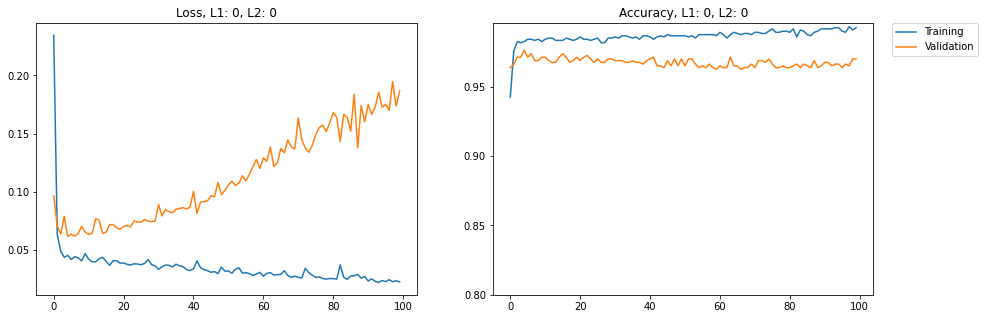

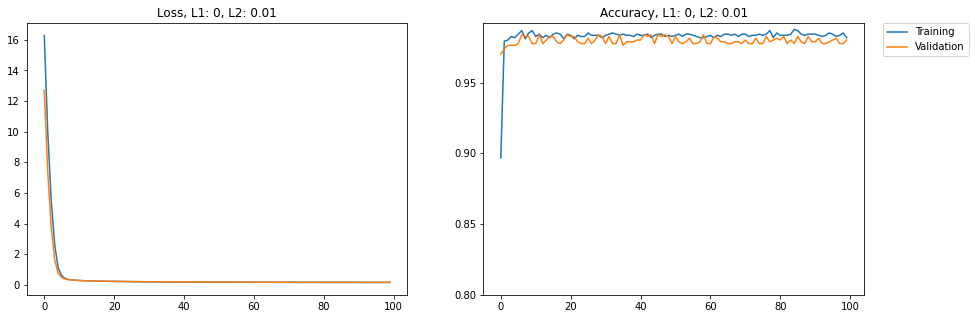

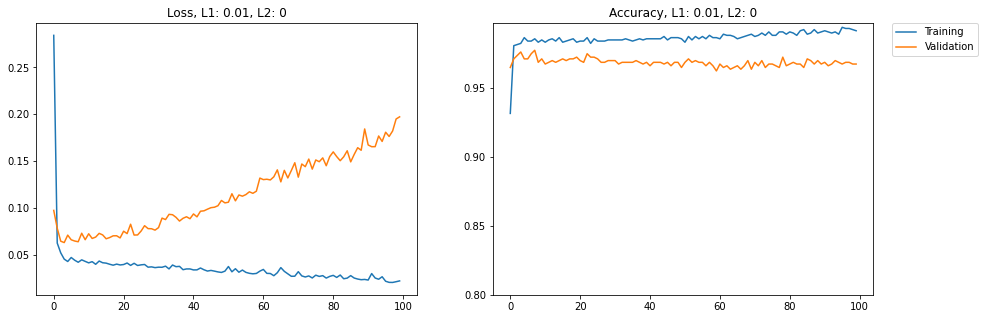

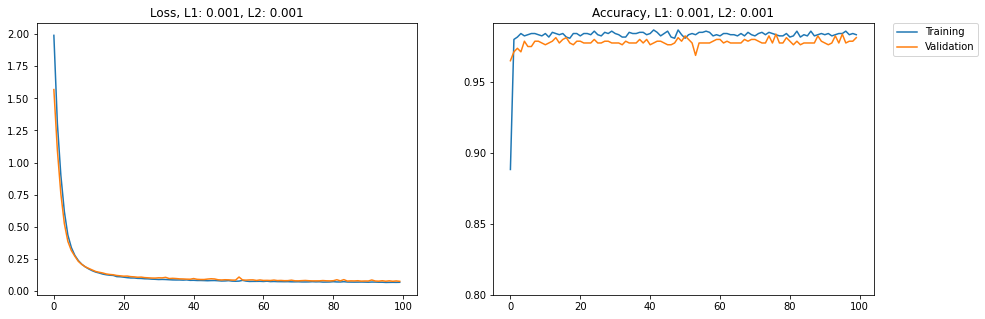

In [ ]:
# 視覺化訓練結果
for k in range(len(l1_l2_list)):
    plt.figure(0, figsize=(15, 5))

    # 繪製 Training loss 和 Validation loss
    plt.subplot(121)
    l1, l2 = l1_l2_list[k]
    loss = train_loss_list[k]
    val_loss = valid_loss_list[k]
    plt.plot(range(len(loss)), loss, label='Training')
    plt.plot(range(len(val_loss)), val_loss, label='Validation')
    title = 'Loss, L1: {}, L2: {}'.format(l1, l2)
    plt.title(title)

    # 繪製 Training accuracy 和 Validation accuracy
    plt.subplot(122)
    l1, l2 = l1_l2_list[k]
    acc = train_acc_list[k]
    val_acc = valid_acc_list[k]
    plt.plot(range(len(acc)), acc, label='Training')
    plt.plot(range(len(val_acc)), val_acc, label='Validation')
    plt.yticks(np.arange(0.8, 1, 0.05))

    title = 'Accuracy, L1: {}, L2: {}'.format(l1, l2)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    plt.show()

### Prediction boundary

接下來，我們將模型的預測邊界畫出來，觀察 `overfitting` 會有什麼現象。

In [ ]:
def plot_boundary(model_dir):
  print(model_dir)
  model = tf.keras.models.load_model(model_dir)
  plot_y = model.predict(plot_data)
  plot_y_class = np.argmax(plot_y, axis=-1)

  plt.figure(figsize=(18,8))
  plt.subplot(1,2,1)
  colors = ['red', 'blue']
  plt.scatter(x1, x2, c = plot_y_class, alpha=0.1, cmap=matplotlib.colors.ListedColormap(colors))
  plt.scatter(X_train[:,0], X_train[:,1], c = y_train[:,1])
  plt.title('Training boundary')

  plt.subplot(1,2,2)
  colors = ['red', 'blue']
  plt.scatter(x1, x2, c = plot_y_class, alpha=0.1, cmap=matplotlib.colors.ListedColormap(colors))
  plt.scatter(X_test[:,0], X_test[:,1], c = y_test[:,1])
  plt.title('Testing boundary')

  plt.show()

#### l1:0, l2:0

save_model/overfitting_l1_0_l2_0.keras


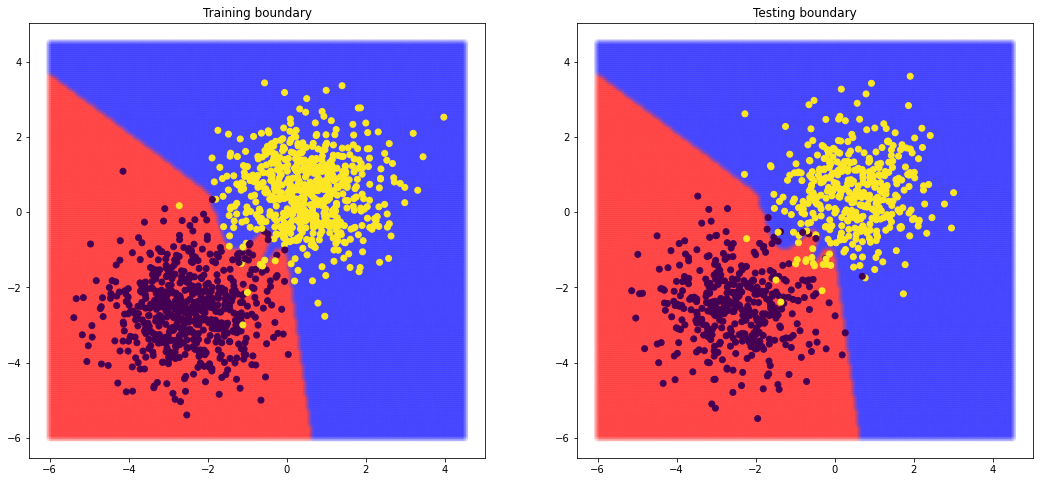

In [ ]:
model_dir = model_list[0]
plot_boundary(model_dir)

#### l1:0, l2:0.01

save_model/overfitting_l1_0_l2_001.keras


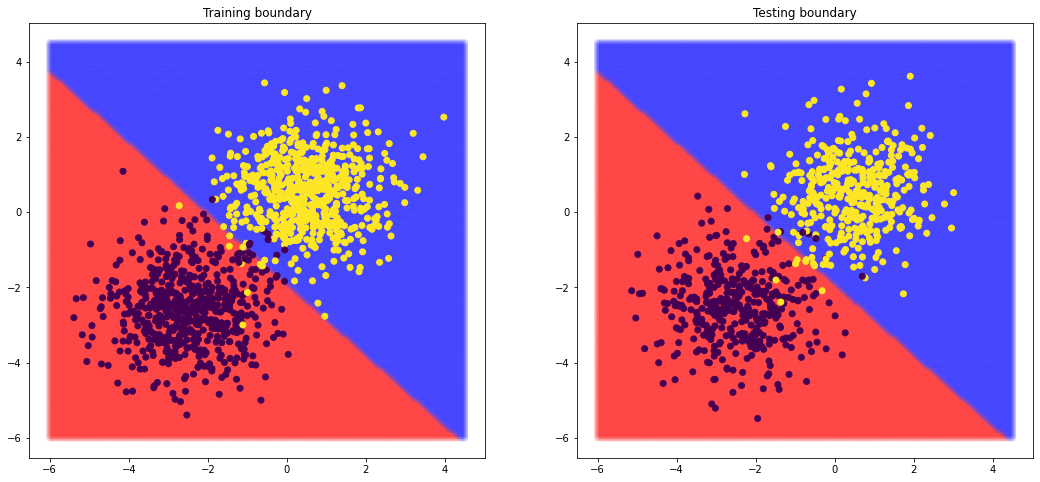

In [ ]:
model_dir = model_list[1]
plot_boundary(model_dir)

#### l1:0.01, l2:0.01

save_model/overfitting_l1_001_l2_0.keras


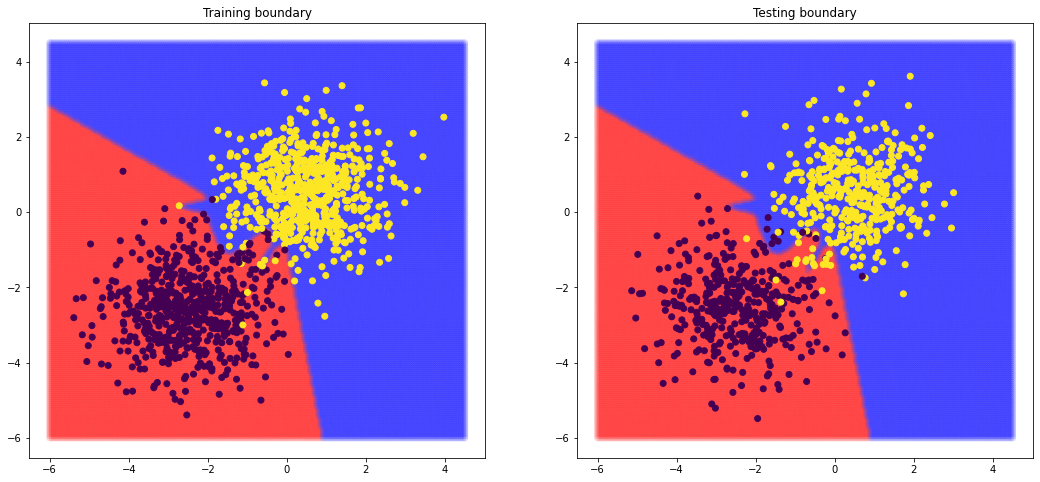

In [ ]:
model_dir = model_list[2]
plot_boundary(model_dir)

#### l1:0.001, l2:0.001

save_model/overfitting_l1_0001_l2_0001.keras


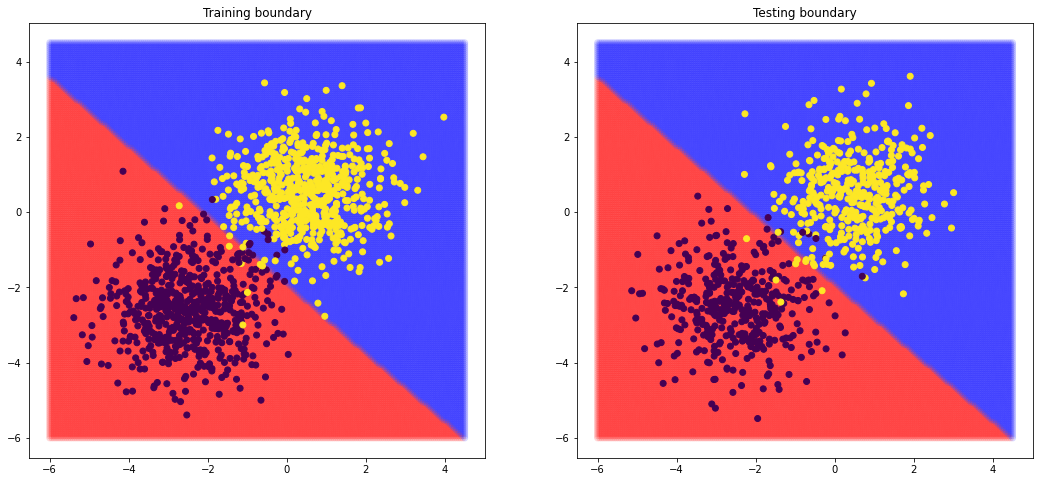

In [ ]:
model_dir = model_list[3]
plot_boundary(model_dir)

## Early stopping

`Early stopping` 這個技巧如其名，在訓練過程中，當要發生 `overfitting` 時就把模型保存下來。

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=14xl2tMXgLRz6osS-1xPdPOGPnSWzTRWa' width="500"/>
<figcaption></figcaption></center>
</figure>

Resource: https://paperswithcode.com/method/early-stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

### 建立模型

In [ ]:
def build_model():

  input = tf.keras.layers.Input(shape=(2,), name='Input_layer')
  dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')(input)
  dense2 = tf.keras.layers.Dense(64, activation='relu', name='dense2')(dense1)
  dense3 = tf.keras.layers.Dense(128, activation='relu', name='dense3')(dense2)
  dense4 = tf.keras.layers.Dense(64, activation='relu', name='dense4')(dense3)
  output = tf.keras.layers.Dense(2, activation='softmax', name='Output_layer')(dense4)

  model = tf.keras.Model(input, output)

  return model

In [ ]:
model = build_model()

# 編譯模型用以訓練 (設定 optimizer, loss function, metrics, 等等)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

#### Callbacks

`Callbacks` 是 `Tensorflow` 中實現各種訓練策略的功能，例如 `Early stopping`, `LearningRateScheduler`, `on_batch_begin`, `on_epoch_begin` 等等，所有功能可以參考 [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)。

In [ ]:
n_patience = 5  # 訓練過程經過 n_patience 次沒有進步之後停止
early_stopping = EarlyStopping(monitor='val_loss',   # 觀察指標
                               patience=n_patience,
                               verbose=1)

### 訓練模型


In [ ]:
# 設定訓練參數
batch_size = 32
epochs = 100

In [ ]:
# 訓練模型
history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              shuffle=True,
              validation_data=(X_test, y_test),
              callbacks=[early_stopping])  # 將 early_stopping 放在 callbacks

Epoch 1/100
38/38 [==============================] - 0s 7ms/step - loss: 0.2869 - accuracy: 0.8867 - val_loss: 0.1100 - val_accuracy: 0.9663
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0658 - accuracy: 0.9792 - val_loss: 0.0744 - val_accuracy: 0.9675
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.9833 - val_loss: 0.0638 - val_accuracy: 0.9737
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0457 - accuracy: 0.9833 - val_loss: 0.0617 - val_accuracy: 0.9750
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0474 - accuracy: 0.9817 - val_loss: 0.0686 - val_accuracy: 0.9712
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0444 - accuracy: 0.9817 - val_loss: 0.0664 - val_accuracy: 0.9712
Epoch 7/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0460 - accuracy: 0.9850 - val_loss: 0.0595 - val_accuracy: 0.9750
Epoch 8/100
3

In [ ]:
# 在 early stopping 之後，記得將模型儲存起來
model_name = 'save_model/early_stopping.keras'
model.save(model_name)

### Loss and accuracy


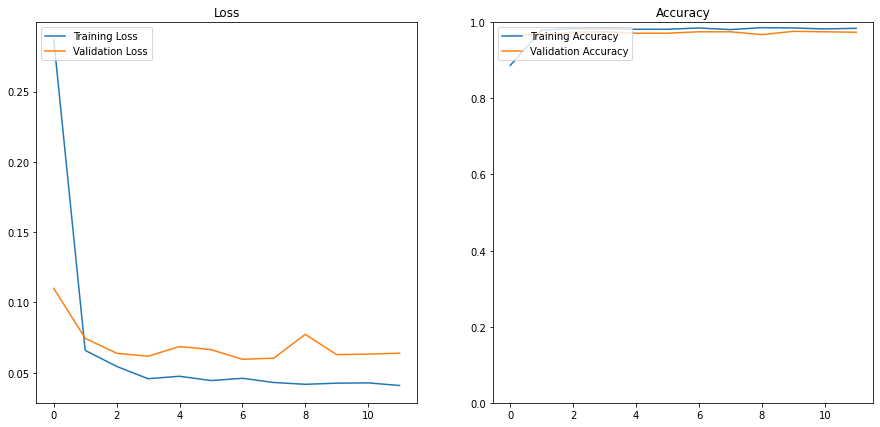

In [ ]:
# 視覺化訓練過程
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15, 7))

# 繪製 Training loss 和 Validation loss
plt.subplot(121)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(122)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.show()

## Dropout



`Dropout` 的做法是模型在每次訓練迭代中，隨機將部分比例的神經元的權重設為 `0`，讓該神經元完全沒有作用，在梯度下降更新也不會更新到該神經元，透過這個方式抑制神經元過度成長，防止 `overfitting`。

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1Kp9SzZ4yxcKxmzxnmEWdmxkOZ9Pdz46X' width="700"/>
<figcaption></figcaption></center>
</figure>


Resource: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

In [ ]:
from tensorflow.keras.layers import Dropout

### 建立模型

In [ ]:
def build_model():
  """
  rate 表示每次將該層的神經元以多少比例設為 0

  假設 rata = 0.3，表示隨機抽出三成的神經元，將其權重設為 0
  """
  input = tf.keras.layers.Input(shape=(2,), name='Input_layer')
  dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')(input)
  dropout1 = Dropout(rate=0.1)(dense1)
  dense2 = tf.keras.layers.Dense(64, activation='relu', name='dense2')(dropout1)
  dropout2 = Dropout(rate=0.3)(dense2)
  dense3 = tf.keras.layers.Dense(128, activation='relu', name='dense3')(dropout2)
  dropout3 = Dropout(rate=0.5)(dense3)
  dense4 = tf.keras.layers.Dense(64, activation='relu', name='dense4')(dropout3)
  dropout4 = Dropout(rate=0.5)(dense4)
  output = tf.keras.layers.Dense(2, activation='softmax', name='Output_layer')(dropout4)

  model = tf.keras.Model(input, output)

  return model

In [ ]:
model = build_model()

# 編譯模型用以訓練 (設定 optimizer, loss function, metrics, 等等)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

### 訓練模型

In [ ]:
# 設定訓練參數
batch_size = 32
epochs = 100

In [ ]:
# 訓練模型
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test, y_test))  # 將 early_stopping 放在 callbacks

Epoch 1/100
38/38 [==============================] - 0s 8ms/step - loss: 0.4787 - accuracy: 0.7958 - val_loss: 0.1961 - val_accuracy: 0.9275
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 0.1245 - accuracy: 0.9583 - val_loss: 0.0837 - val_accuracy: 0.9712
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.9775 - val_loss: 0.0822 - val_accuracy: 0.9712
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.9750 - val_loss: 0.0767 - val_accuracy: 0.9700
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0678 - accuracy: 0.9767 - val_loss: 0.0740 - val_accuracy: 0.9725
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0602 - accuracy: 0.9833 - val_loss: 0.0727 - val_accuracy: 0.9700
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0610 - accuracy: 0.9800 - val_loss: 0.0716 - val_accuracy: 0.9688
Epoch 8/100
3

In [ ]:
# 在訓練完成之後，記得將模型儲存起來
model_name = 'save_model/dropout.keras'
model.save(model_name)

### Loss and accuracy


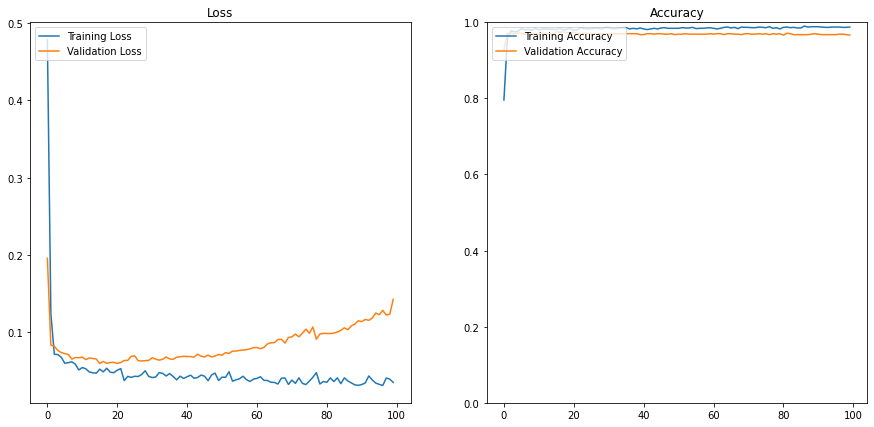

In [ ]:
# 視覺化訓練過程
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15, 7))

# 繪製 Training loss 和 Validation loss
plt.subplot(121)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(122)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.show()